In [26]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
FRAME_SIZE_MODEL = 300

In [158]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="../model-zoo/object-detection/SSD MobileNetV1/lite-model_ssd_mobilenet_v1_1_metadata_2.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_index = interpreter.get_input_details()[0]["index"]

# Load labels
with open("../model-zoo/object-detection/SSD MobileNetV1/labelmap.txt", 'r') as f:
    labels = f.read().splitlines()

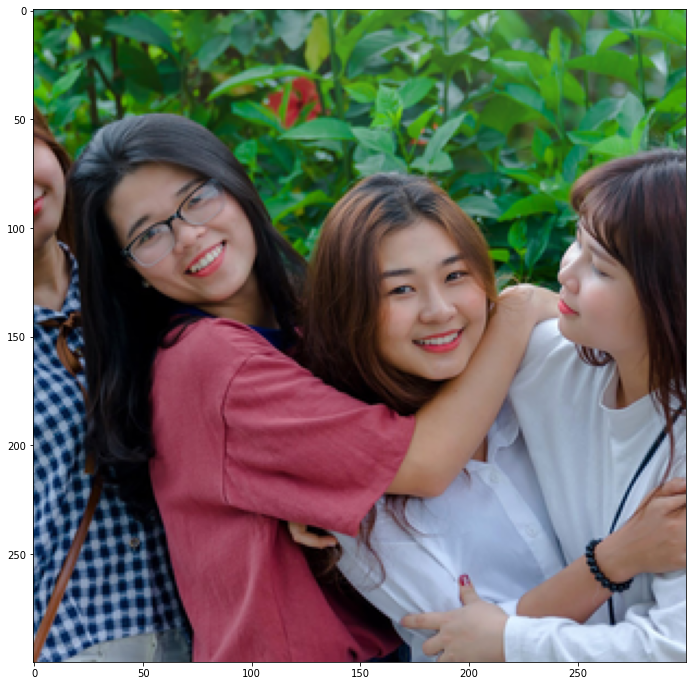

In [159]:
# Read the image and decode to a tensor
img_rgb = Image.open("../images/group-of-four-girl-friends.jpg")
#img_rgb = Image.open("../images/traffic.jpg")
#img_rgb = Image.open("../images/cat-and-dog.jpg")
#img_rgb = Image.open("../images/produce.jpg")

crop_size= min(img_rgb.size)
scale = crop_size / 1080

# crop to square and resize for model input
img_cropped = img_rgb.crop(((img_rgb.size[0]-crop_size)/2, (img_rgb.size[1]-crop_size)/2, (img_rgb.size[0]-crop_size)/2 + crop_size, (img_rgb.size[1]-crop_size)/2 + crop_size))
img_resized = img_cropped.copy()
img_resized.thumbnail((FRAME_SIZE_MODEL, FRAME_SIZE_MODEL), Image.ANTIALIAS)

#img_resized = image. cv2.resize(img_rgb,(FRAME_SIZE_MODEL, FRAME_SIZE_MODEL))

#Preprocess the image to required size and cast
input_shape = input_details[0]['shape']
input_tensor= np.array(np.expand_dims(np.asarray(img_resized),0), dtype=np.uint8)
input_index = interpreter.get_input_details()[0]["index"]

# Display Resized Image
plt.figure(figsize=(12,12))
plt.imshow(img_resized);

In [160]:
# Set input data
interpreter.set_tensor(input_index, input_tensor)

# Run the inference
interpreter.invoke()
output_details = interpreter.get_output_details()

# location is [top, left, bottom, right] relative (0..1) to input dimensions
location = np.squeeze(interpreter.get_tensor(output_details[0]['index']))
category = np.squeeze(interpreter.get_tensor(output_details[1]['index']))
score = np.squeeze(interpreter.get_tensor(output_details[2]['index']))

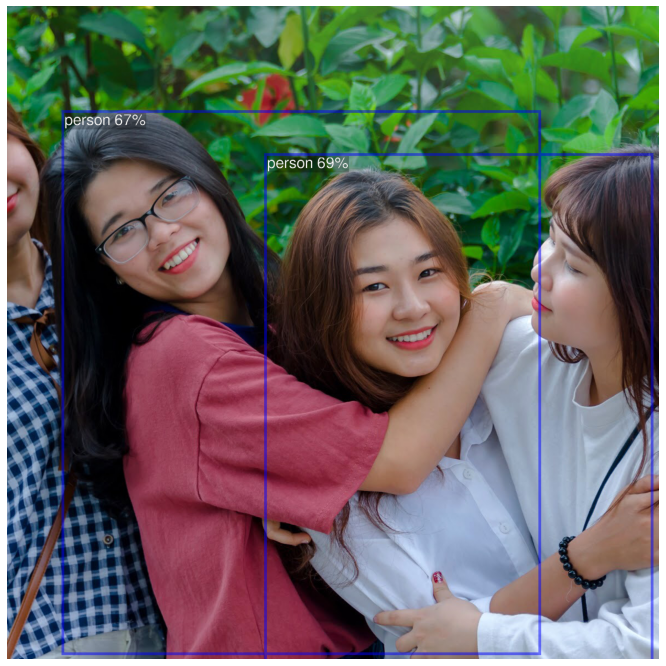

In [161]:
# make a blank image for the text, initialized to transparent text color
canvas = Image.new("RGBA", img_cropped.size, (255,255,255,0))

# get a font
fnt = ImageFont.truetype("Pillow/Tests/fonts/FreeSans.ttf", int(26 * scale))
# get a drawing context
d = ImageDraw.Draw(canvas)

outline_width = int(5*scale)

for i in range(10):
    if score[i] > 0.6:
        class_text = '{} {:.0f}%'.format(labels[int(category[i])], score[i]*100) 

        # Image needs [left, top, right, bottom]
        rect = np.array([location[i][1], location[i][0], location[i][3], location[i][2]]) * crop_size
        
        # draw text, half opacity
        text_dim = d.textsize(class_text, font=fnt)
        bbox = ( rect[0] + outline_width, rect[1], rect[0] + text_dim[0] + outline_width, rect[1] + text_dim[1] + outline_width)
        
        # draw elements
        d.rectangle(bbox, fill=(0,0,0,64))
        d.rectangle(rect, outline=(0,0,255,128), width=outline_width)
        d.text(( rect[0] + outline_width, rect[1] + outline_width), class_text, font=fnt, fill=(255,255,255,255))

# Create composize image with canvas
composite = Image.alpha_composite(img_cropped.convert("RGBA"), canvas)

# Display Image with overlay
plt.figure(figsize=(12,12))
plt.axis("off")
plt.imshow(composite);